In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import numpy as np
import pygritbx as pgt

In [2]:
# Unit Vectors for defining reference frame
i = np.array([1, 0, 0])
j = np.array([0, 1, 0])
k = np.array([0, 0, 1])
referenceFrame = np.array([i, j, k])

In [3]:
# Axial dimensions on Shaft A1
a1 = 9 + 28.75 + 9 # [mm]
b1 = (13.25 - 9) + 24.25 + 30 / 2 # [mm]
zR1 = a1 + b1 # [mm]

In [4]:
# Axial dimension on shaft A1'
zR2 = 0 # [mm]
zR3 = 55 # [mm]

In [5]:
# Axial dimension on shaft A2
zR4 = 17 + 18 / 2 # [mm]
a2 = (46 - zR4) + 9.25 # [mm]
b2 = 16 + 25 + 16 # [mm]
c2 = (58.5 - 16) + 35 # [mm]


In [6]:
# Input
motor = pgt.Motor(name="M1", loc=0, power=6e3, n=2750, axis=k)

In [7]:
# Material
shaftMaterial = pgt.Material(name='34NiCrMo6', sigma_u=1050, sigma_y=950, sigma_Dm1=520, HB=0)
R1R4_material = pgt.Material(name='Steel', sigma_u=1060, sigma_y=950, sigma_Dm1=0, HB=335)
R2R3_material = pgt.Material(name='Steel', sigma_u=1950, sigma_y=1400, sigma_Dm1=0, HB=560)

In [8]:
# Gears
# R1
R1 = pgt.Gear(name="R1", axis=k, loc=zR1, m_n=2.5, z=18, psi=20, phi_n=20, Q_v=7, FW=30, material=R1R4_material)

# R2
R2 = pgt.Gear(name="R2", axis=k, loc=zR2, m_n=2.5, z=73, psi=-20, phi_n=20, Q_v=7, FW=30, material=R2R3_material)

# R3
R3 = pgt.Gear(name="R3", axis=k, loc=zR3, m_n=2.5, z=19, psi=-20, phi_n=20, Q_v=7, FW=30, material=R2R3_material)

# R4
R4 = pgt.Gear(name="R4", axis=k, loc=zR4, m_n=2.5, z=51, psi=20, phi_n=20, Q_v=7, FW=30, material=R1R4_material)

In [9]:
# Supports
# A (roller 30203)
A = pgt.Support(name="A", type="Roller", bearingType="Tapered", catalogueName="30203", catalogueType="Explorer",
                     d=17, D=40, B=13.25, C=23.4e3, C0=18.6e3, Pu=1.83e3, nr=15e3, a=9, e=0.35, X=0, Y=1.7, Y0=0.9, Y1=0,
                     Y2=0, A=0, kr=0, shoulder=-1, arr="B2B", axis=k, loc=0)

# B (roller 30203)
B = pgt.Support(name="B", type="Pin", bearingType="Tapered", catalogueName="30203", catalogueType="Explorer",
                     d=17, D=40, B=13.25, C=23.4e3, C0=18.6e3, Pu=1.83e3, nr=15e3, a=9, e=0.35, X=0, Y=1.7,Y0=0.9, Y1=0,
                     Y2=0, A=0, kr=0, shoulder=1, arr="B2B", axis=k, loc=a1)

# C (roller 30208)
C = pgt.Support(name="C", type="Roller", bearingType="Tapered", catalogueName="30208", catalogueType="Explorer",
                     d=40, D=80, B=19.75, C=75.8e3, C0=68e3, Pu=7.65e3, nr=7e3, a=16, e=0.37, X=0, Y=1.6, Y0=0.9, Y1=0,
                     Y2=0, A=0, kr=0, shoulder=-1, arr="B2B", axis=k, loc=zR4 + a2)

# D (roller 30208)
D = pgt.Support(name="D", type="Pin", bearingType="Tapered", catalogueName="30208", catalogueType="Explorer",
                     d=40, D=80, B=19.75, C=75.8e3, C0=68e3, Pu=7.65e3, nr=7e3, a=16, e=0.37, X=0, Y=1.6, Y0=0.9, Y1=0,
                     Y2=0, A=0, kr=0, shoulder=1, arr="B2B", axis=k, loc=zR4 + a2 + b2)

# F
F = pgt.Support(axis=k)

In [10]:
# Output Component
output = pgt.Component("Output", None, k, zR4 + a2 + b2 + c2)

In [11]:
# Gearbox Configuration
# Shaft A1
A1 = pgt.Shaft(name="A1", inputs=[motor], outputs=[R1], axis=k, material=shaftMaterial, sups=np.array([A, B]), loc=[0, 0, 0])
# Mesh M1
M1 = pgt.GearMesh(name="M1", drivingGear=R1, drivenGear=R2, radiality=[-j], type="External")
# Shaft A1'
A1_p = pgt.Shaft("A1'", [R2], [R3], -k, shaftMaterial, np.array([F, F]))
# Mesh M2
M2 = pgt.GearMesh("M2", R3, R4, [j], "External")
# Shaft A2
A2 = pgt.Shaft("A2", [R4], [output], k, shaftMaterial, np.array([C, D]))

In [12]:
A1.solve()

Checking torque equilibrium for A1.
A1 does not mainatain a torque equilibrium.
Checking solvability for A1.
Solving torque equilibrium for A1.
Torque equilibrium for A1 is solved.
Checking torque equilibrium for R1.
R1 does not mainatain a torque equilibrium.
Checking solvability for R1.
Solving forces on R1 due to mesh M1.
Checking torque equilibrium for R1.
R1 mainatains a torque equilibrium.
Checking force equilibrium on A1.
A1 does not maintain a force equilibrium.
Axial reaction forces on A1 with Tapered bearings: Case 1a
Checking force equilibrium on A1.
A1 maintains a force equilibrium.


In [13]:
R1.EFs[0].force, R1.ETs[0].torque

(array([-870.14822159,  337.03366936,  316.70805206]),
 array([ -0.        ,  -0.        , -20.83482891]))

In [14]:
A.F_tot.force, B.F_tot.force

(array([-809.65663399,  475.8122391 , -865.57152262]),
 array([1679.80485557, -812.84590846,  548.86347056]))

In [15]:
A1.EFs[0].force, A1.EFs[1].force, A1.EFs[2].force, A1.EFs[3].force

(array([0, 0, 0]),
 array([-870.14822159,  337.03366936,  316.70805206]),
 array([-809.65663399,  475.8122391 , -865.57152262]),
 array([1679.80485557, -812.84590846,  548.86347056]))

In [16]:
R1.solve()

Checking torque equilibrium for R1.
R1 mainatains a torque equilibrium.
Nothing to be solved for R1.


In [17]:
R2.solve()

Checking torque equilibrium for R2.
Checking solvability for R2.
Solving torque equilibrium for R2.
Checking torque equilibrium for R2.
R2 mainatains a torque equilibrium.


In [18]:
A1_p.solve()

Checking torque equilibrium for A1'.
A1' does not mainatain a torque equilibrium.
Checking solvability for A1'.
Solving torque equilibrium for A1'.
Torque equilibrium for A1' is solved.
Checking torque equilibrium for R3.
R3 does not mainatain a torque equilibrium.
Checking solvability for R3.
Solving forces on R3 due to mesh M2.
Checking torque equilibrium for R3.
R3 mainatains a torque equilibrium.
Checking force equilibrium on A1'.
A1' does not maintain a force equilibrium.
Reaction forces on A1' won't be calculated.


In [19]:
R3.solve()

Checking torque equilibrium for R3.
R3 mainatains a torque equilibrium.
Nothing to be solved for R3.


In [20]:
R4.solve()

Checking torque equilibrium for R4.
Checking solvability for R4.
Solving torque equilibrium for R4.
Checking torque equilibrium for R4.
R4 mainatains a torque equilibrium.


In [21]:
Fout_r = np.abs(np.sum(R4.ETs[0].torque)) / 0.1 * j
Fout_a = 0.25 * np.abs(np.sum(Fout_r)) * (-k)
Fout = pgt.Force(Fout_a + Fout_r, output.abs_loc)
A2.outputs[0].updateEFs([Fout])

In [22]:
A2.solve()

Checking torque equilibrium for A2.
A2 does not mainatain a torque equilibrium.
Checking solvability for A2.
Solving torque equilibrium for A2.
Torque equilibrium for A2 is solved.
Checking force equilibrium on A2.
A2 does not maintain a force equilibrium.
Axial reaction forces on A2 with Tapered bearings: Case 2a
Checking force equilibrium on A2.
A2 maintains a force equilibrium.


In [23]:
C.F_tot.force, D.F_tot.force

(array([-5058.79108048,  -323.8988148 , -1584.10924911]),
 array([ 1715.5900186 , -3239.09218522,  3367.95296407]))

In [24]:
# Shaft A2: profile for static verification
statProfile = pgt.ShaftProfile(name="A2 Static Profile",
                                  radii=np.array([34, 35, 35, 30, 30, 35, 35, 40, 40, 34, 34, 32, 32, 27, 27, 32, 32, 31]) / 2, 
                                  locs=np.array([0, 1, 11.9, 12, 39.9, 40, 45.9, 46, 132.9, 133, 158.4, 158.5, 178.4, 178.5, 208.4, 208.5, 222, 223]))
statProfile_refined = statProfile.refineProfile(delta=0.1)
statProfile_refined.addFillet(radius=1, quadrant=[2], zOff=45, dOff=18.5)
statProfile_refined.addFillet(radius=1, quadrant=[1], zOff=134, dOff=18)
A2.addProfile(profile=statProfile_refined)

In [25]:
# Shaft A2: define sections
# v1
v1 = pgt.ShaftSection(name='V1', loc=26, d=30, Ra=0.8, material=shaftMaterial)
v1.appendKf(Kf=np.array([1.6, 2]), loadType=np.array(["Bending", "Torsion"]))

In [26]:
# v2
v2 = pgt.ShaftSection(name='V2', loc=46, d=40, Ra=0.8, material=shaftMaterial)
v2.addNotchSensitivity(notchRadius=1, sigma_u=A2.material.sigma_u)
v2.addGeometricStressRaiser(r2d=1/35, D2d=40/35)

In [27]:
# v3
v3 = pgt.ShaftSection(name='V3', loc=133, d=40, Ra=0.8, material=shaftMaterial)
v3.addNotchSensitivity(notchRadius=1, sigma_u=A2.material.sigma_u)
v3.addGeometricStressRaiser(r2d=1/34, D2d=40/34)

In [28]:
userSections = np.array([v1, v2, v3])
A2.addSections(sections=userSections)

Initiating static verification on shaft A2.
Calculating internal loads on shaft A2.


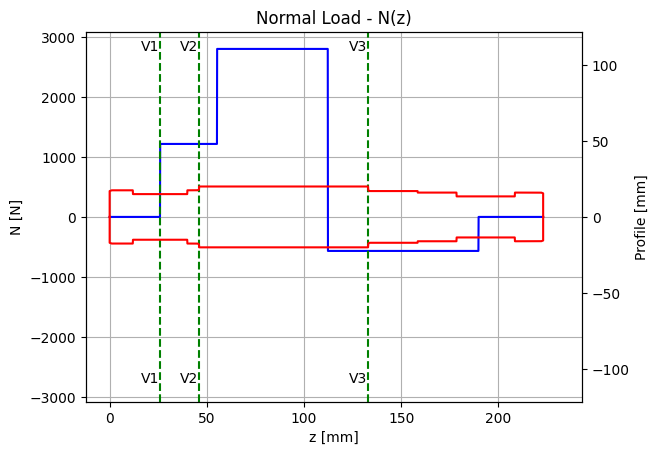

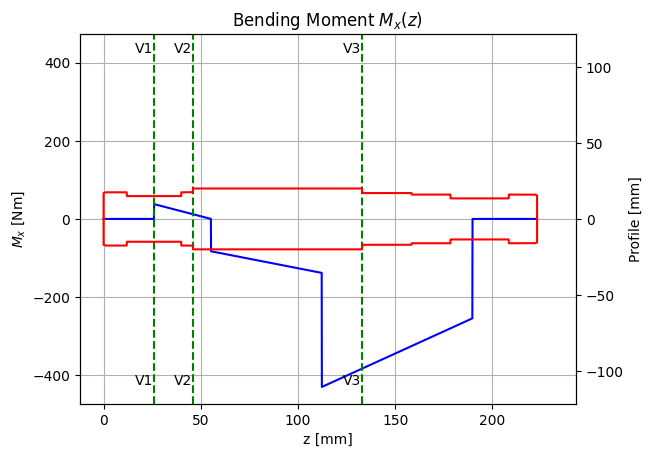

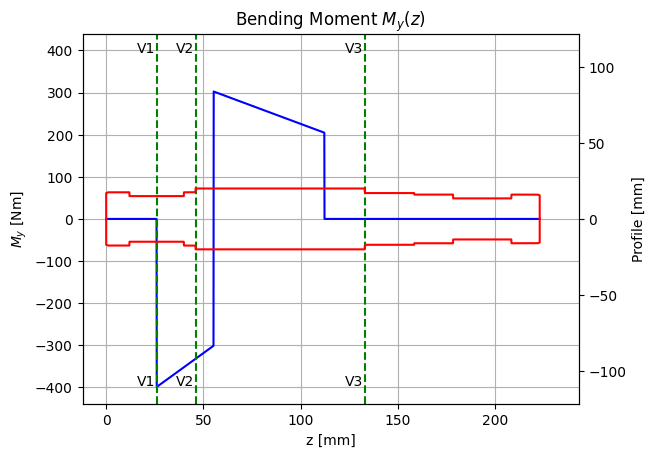

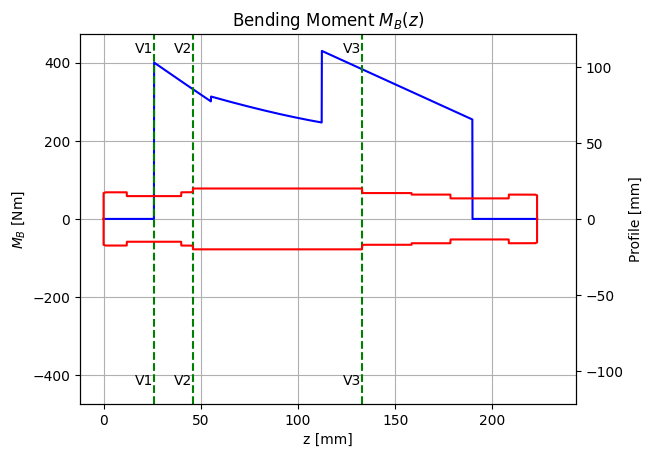

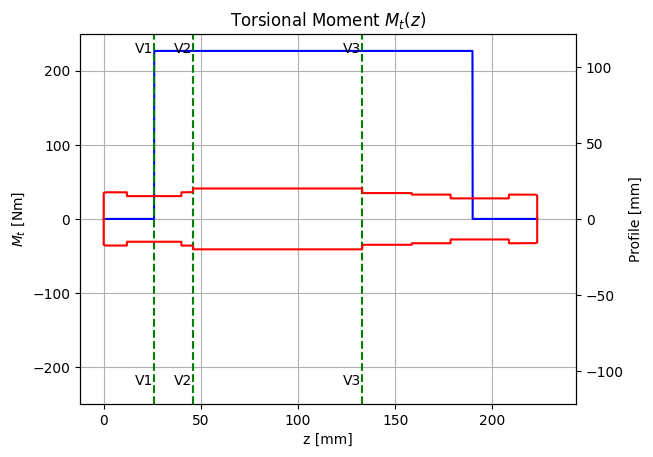

Calculating stresses on shaft A2 along profile 'A2 Static Profile'.


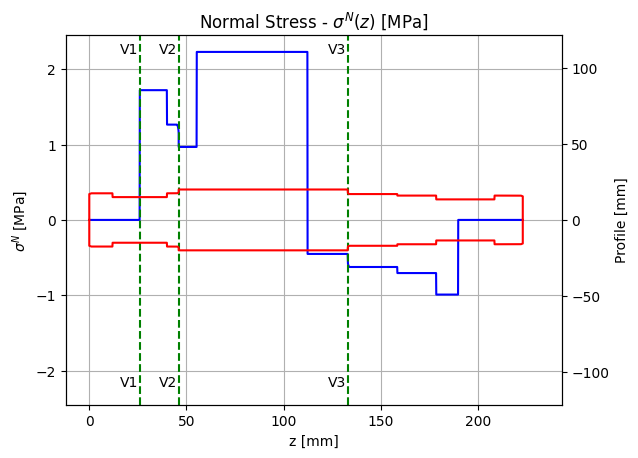

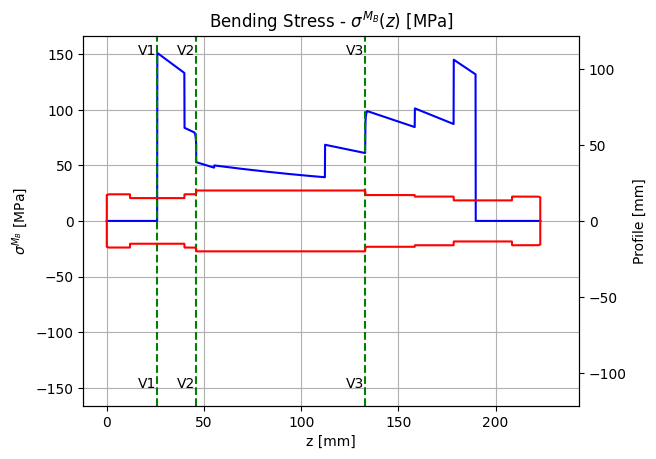

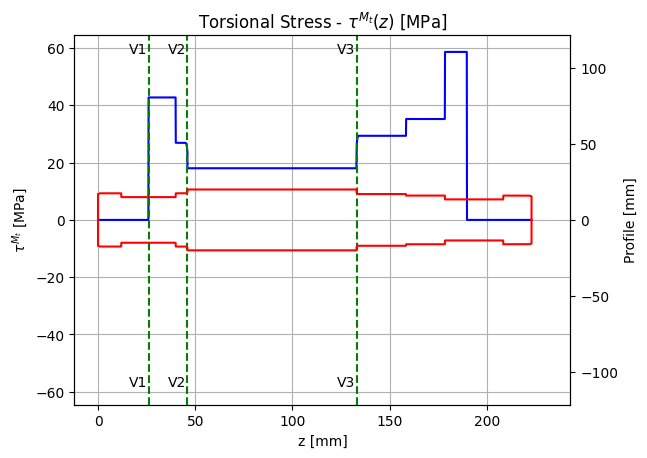

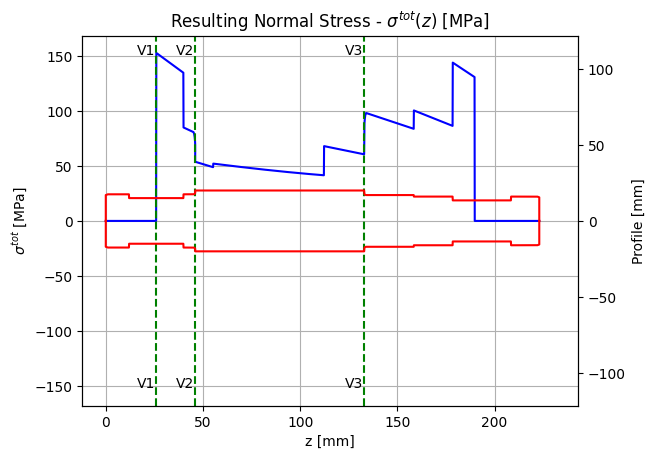

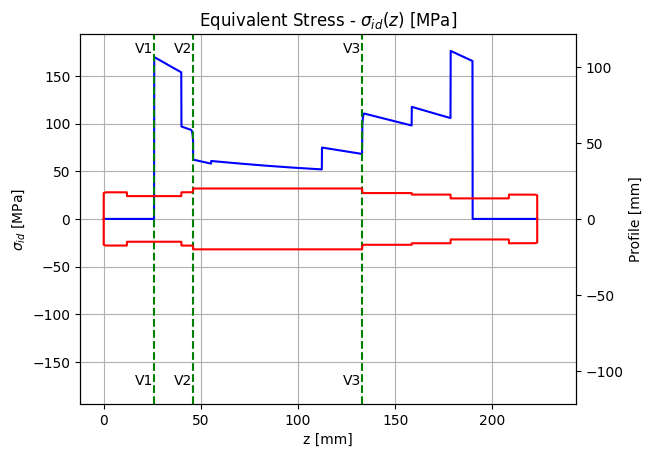

Calculating static safety factor for every user-defined section.
Section Name: Static Safety Factor
Section V1: 5.59 [-].
Section V2: 15.27 [-].
Section V3: 10.16 [-].


In [29]:
A2.performStaticVerification(RF=referenceFrame, profile=A2.profiles[0])

In [30]:
# Shaft A2: profile for fatigue verification
fatigueProfile = pgt.ShaftProfile(name="A2 Fatigue Profile",
                                     radii=np.array([34, 35, 35, 40, 40, 34, 34, 32, 32, 31]) / 2,
                                     locs=np.array([0, 1, 45.9, 46, 132.9, 133, 158.4, 158.5, 222, 223]))

fatigueProfile_refined = fatigueProfile.refineProfile(delta=0.1)
fatigueProfile_refined.addFillet(radius=1, quadrant=[2], zOff=45, dOff=18.5)
fatigueProfile_refined.addFillet(radius=1, quadrant=[1], zOff=134, dOff=18)
A2.addProfile(profile=fatigueProfile_refined)
A2.sections[0].d = 35
userSections[0].d = 35

Initiating fatigue verification on shaft A2.
Internal loads for shaft A2 already calculated.


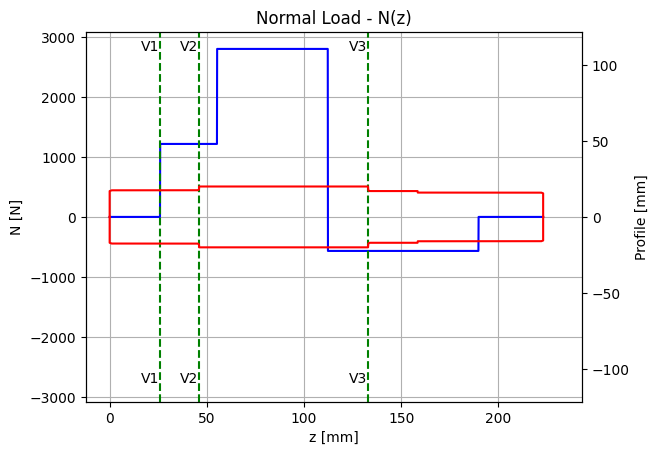

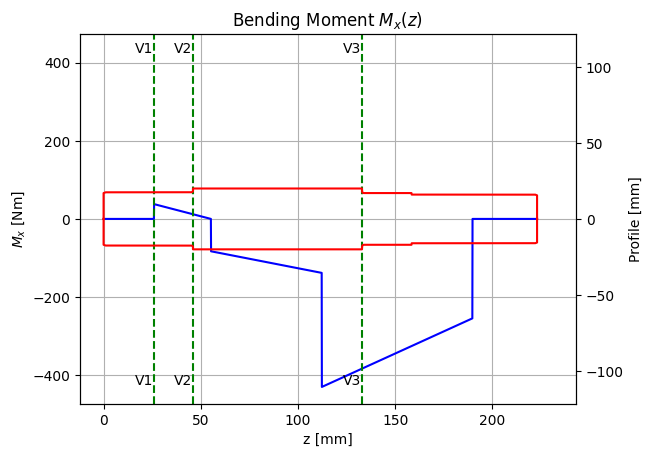

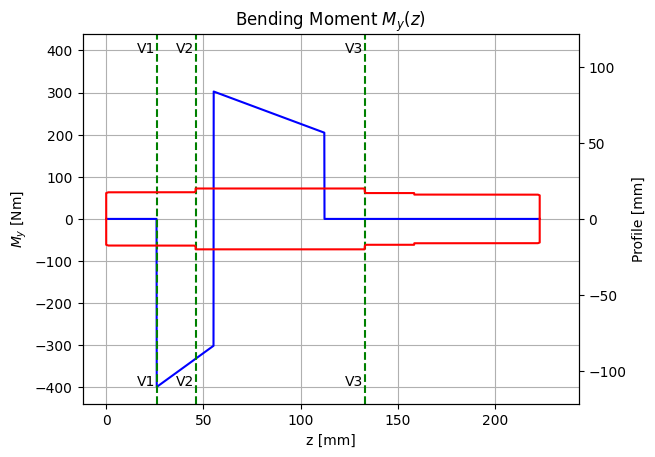

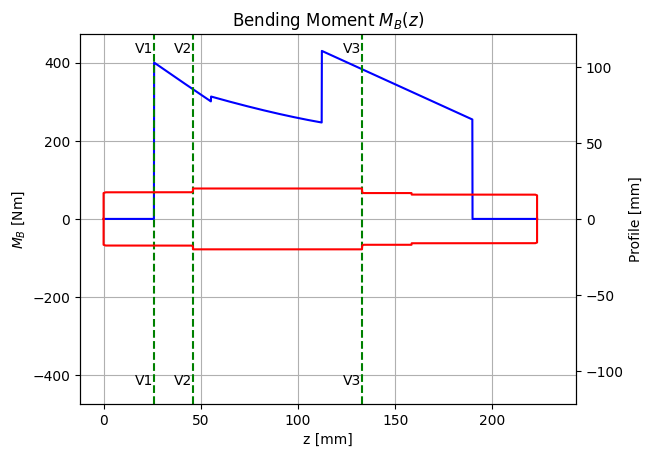

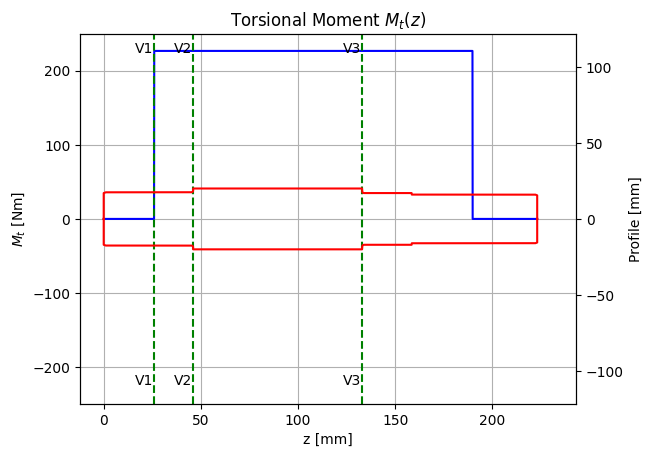

Calculating stresses on shaft A2 along profile 'A2 Fatigue Profile'.


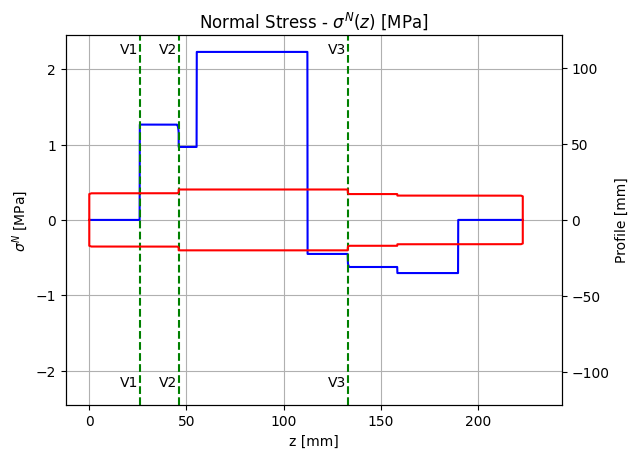

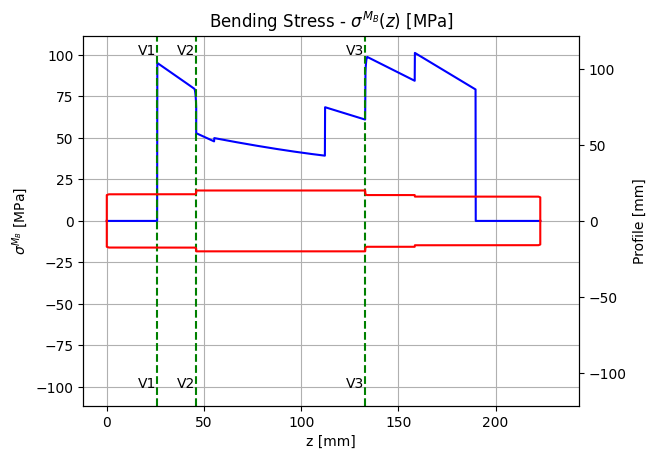

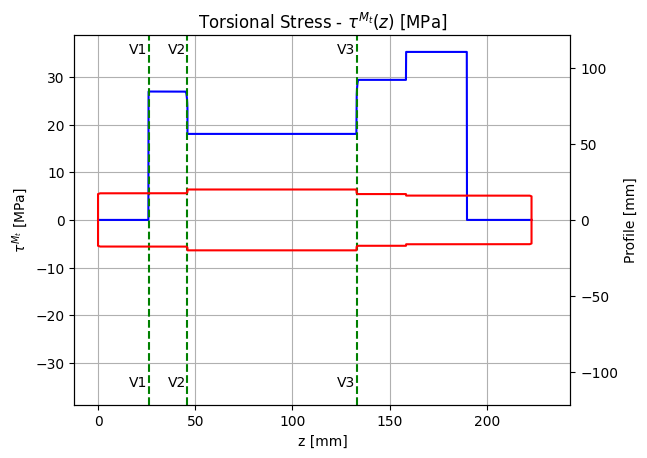

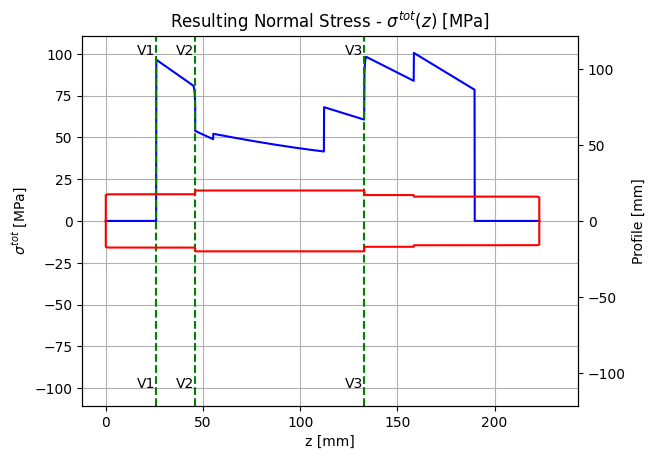

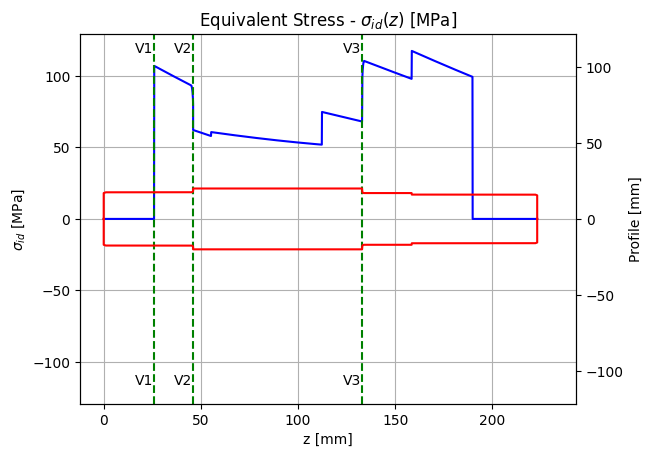

Calculating mean and alternating stresses for every user-defined section.
Calculating fatigue limit corrector factors on every user-defined section.
Calculating equivalent mean and alternating stresses along every user-defined section.


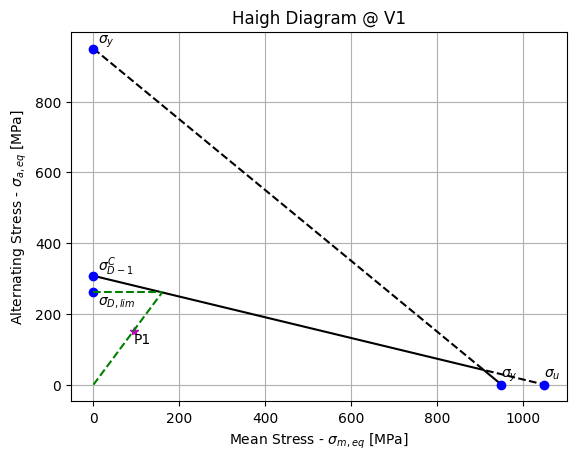

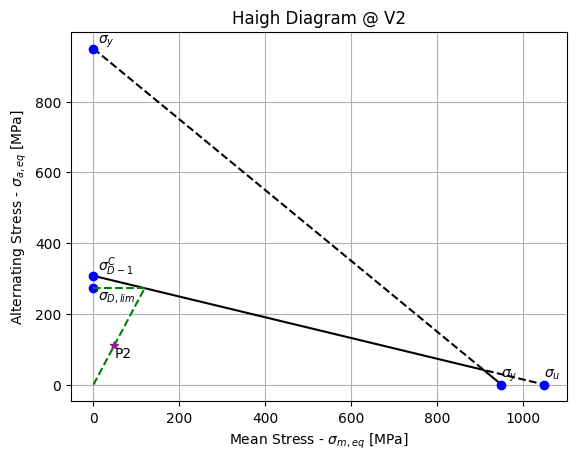

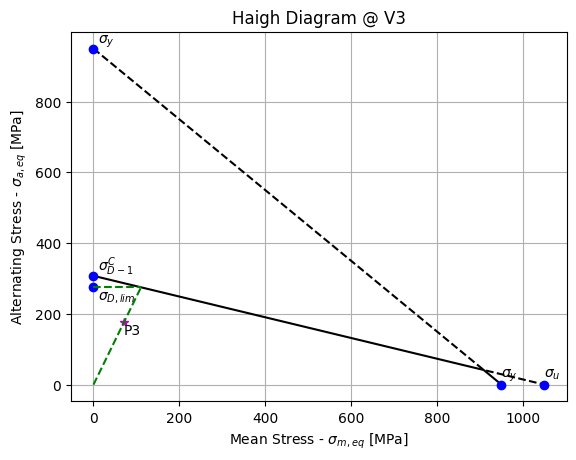

Calculating fatigue safety factor for every user-defined section.
Section Name: Fatigue Safety Factor
V1: 1.71 [-].
V2: 2.46 [-].
V3: 1.56 [-].


In [31]:
A2.performFatigueVerification(RF=referenceFrame, profile=A2.profiles[1])

In [32]:
R1.analyseGearToothBending(mesh=M1, powerSource="Uniform", drivenMachine="Uniform", dShaft=35, Ce=1, teethCond="uncrowned teeth",
                           lShaft=a1+b1+50, useCond="Commercial, enclosed units", sigma_FP=320, b_YN=1.3558, e_YN=-0.0178,
                           N=1e8, temp=60, rel=0.99)

Initiating gear tooth bending analysis for gear R1.
Calculating maximum gear tooth bending stress for fatigue.
Maximum gear tooth bending stress for fatigue for gear R1: 87.86 [MPa].
Calculating bending safety factor for gear R1.
Gear tooth bending safety factor for gear R1: 3.56 [-].


In [33]:
R3.analyseGearToothBending(mesh=M2, powerSource="Uniform", drivenMachine="Uniform", dShaft=30, Ce=1, teethCond="uncrowned teeth",
                           lShaft=70, useCond="Commercial, enclosed units", sigma_FP=450, b_YN=1.3558, e_YN=-0.0178,
                           N=1e8, temp=60, rel=0.99)

Initiating gear tooth bending analysis for gear R3.
Calculating maximum gear tooth bending stress for fatigue.
Maximum gear tooth bending stress for fatigue for gear R3: 131.62 [MPa].
Calculating bending safety factor for gear R3.
Gear tooth bending safety factor for gear R3: 3.34 [-].


In [34]:
R1.analyseGearToothPitting(mesh=M1, Z_R=1, sigma_HP=860, b_ZN=1.4488, e_ZN=-0.023, N=1e8)

Initiating gear tooth pitting analysis for gear R1.
Calculating maximum gear contact stress.
Maximum gear contact stress for gear R1: 315.86 [MPa].
Calculating wear safety fator for gear R1.
Wear safety factor for gear R1: 2.58 [-].


In [35]:
R3.analyseGearToothPitting(mesh=M2, Z_R=1, sigma_HP=1360, b_ZN=1.4488, e_ZN=-0.023, N=1e8)

Initiating gear tooth pitting analysis for gear R3.
Calculating maximum gear contact stress.
Maximum gear contact stress for gear R3: 562.66 [MPa].
Calculating wear safety fator for gear R3.
Wear safety factor for gear R3: 2.32 [-].


In [36]:
# Define oil of choice
oil = pgt.Oil("ISO VG 100", 60, 15, 45)

In [37]:
A.performLifeAnalysis(rel=95, condition="Slight contamination", a_skf=2, oil=oil)

Initiating Life Analysis on bearing A.
Checking minimum load condition.
Bearing A satisfies minimium load condition.
Calculating static safety factor.
Bearing A's equivalent static load: 3219.33 [N].
Bearing A's static safety factor: 5.78 [-].
Calculating reliability factor.
Bearing A's reliability factor: 0.64 [-].
Calculating equivalent dynamic load.
Bearing A's equivalent dynamic load: 1635.01 [N].
Calculating contamination factor based on given condition: 'Slight contamination'.
Bearing A's contamination factor: 0.40 [-].
Calculating bearing life.
Bearing A life analysis results: 9110.13 [million cycles] | 55212.92 [hours].


In [38]:
B.performLifeAnalysis(rel=95, condition="Slight contamination", a_skf=5, oil=oil)

Initiating Life Analysis on bearing B.
Checking minimum load condition.
Bearing B satisfies minimium load condition.
Calculating static safety factor.
Bearing B's equivalent static load: 2264.08 [N].
Bearing B's static safety factor: 8.22 [-].
Calculating reliability factor.
Bearing B's reliability factor: 0.64 [-].
Calculating equivalent dynamic load.
Bearing B's equivalent dynamic load: 1770.11 [N].
Calculating contamination factor based on given condition: 'Slight contamination'.
Bearing B's contamination factor: 0.40 [-].
Calculating bearing life.
Bearing B life analysis results: 17479.83 [million cycles] | 105938.39 [hours].


In [39]:
C.performLifeAnalysis(rel=95, condition="Slight contamination", a_skf=1, oil=oil)

Initiating Life Analysis on bearing C.
Checking minimum load condition.
Bearing C satisfies minimium load condition.
Calculating static safety factor.
Bearing C's equivalent static load: 9028.74 [N].
Bearing C's static safety factor: 7.53 [-].
Calculating reliability factor.
Bearing C's reliability factor: 0.64 [-].
Calculating equivalent dynamic load.
Bearing C's equivalent dynamic load: 7603.04 [N].
Calculating contamination factor based on given condition: 'Slight contamination'.
Bearing C's contamination factor: 0.40 [-].
Calculating bearing life.
Bearing C life analysis results: 1364.96 [million cycles] | 90053.91 [hours].


In [40]:
D.performLifeAnalysis(rel=95, condition="Slight contamination", a_skf=2, oil=oil)

Initiating Life Analysis on bearing D.
Checking minimum load condition.
Bearing D satisfies minimium load condition.
Calculating static safety factor.
Bearing D's equivalent static load: 9841.69 [N].
Bearing D's static safety factor: 6.91 [-].
Calculating reliability factor.
Bearing D's reliability factor: 0.64 [-].
Calculating equivalent dynamic load.
Bearing D's equivalent dynamic load: 4563.06 [N].
Calculating contamination factor based on given condition: 'Slight contamination'.
Bearing D's contamination factor: 0.40 [-].
Calculating bearing life.
Bearing D life analysis results: 14971.13 [million cycles] | 987728.22 [hours].
